In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
df = pd.read_csv('student-por.csv', ';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


**1. Разбейте выборку случайным образом на обучение и контроль (train_test_split из sklearn). В обучение попадает 30% выборки, в контроль 70%. Разбейте контроль в отношении 4:3. Большая часть - контрольная выборка, которой вы будете пользоваться. Меньшая часть - скрытый контроль - используется только в последнем пункте.**

In [3]:
# X - набор номеров, присвоенных студентам, длина которого равна количеству строк в исходной таблице
X = np.arange(df.shape[0])

# разбиваем выборку на обучение и контроль в заданном соотношении
X_train, X_test = train_test_split(X, test_size=0.7)

# разбиваем контроль (X_test) в отношении 4:3, т.е. в используемую контрольную выборку попадет ~57%
X_control, X_concealed = train_test_split(X_test, train_size=0.57)

print(X_train, len(X_train))
print(X_control, len(X_control))
print(X_concealed, len(X_concealed))

[528 135 277  16 473 420 372 263 262 316 405 551 314 491  25 195 529 508
 426 453 202 122 437 236 355 271 342 626 639 381 288 443  94   8 550  89
 359 540 612 346 385 427  15 327 305 484 299 524 618 349 382 383  50 300
 638 219 363  99 511 237 493 295 244 578 559 175 609 590 149 471 554 139
 126  63 403 151 337 206 367 141 378 107 419 631 574   4 230   1 200 362
 472 238 279 231 449 286 205 118 272 404  47 108  68 130  64 573 616 106
 489 318 306 402 133 636 321 353 276 494 497  90 188 373  22 523 401 340
 394 433 253 533 454 105 455 311 474 595 303 526 203 407  82   7 199 225
  67 308 384 216  43 581  20 124 615 323 431 290 338 269 632 198 460 393
  56  51  91 304 211 504 115   2 418 208  30 591 140 633 552 586 132 530
 335 495 121 375  54 110 146 468 161 451 201  73 553 370] 194
[387 223 291  84 100 429 261   6 521  79 176 434 558 157 254 366 556 250
  83 137 503  36 193  34 148 450 417 396 152 490  35 641 512 350 391 510
 601  44 446 348 517 607 196 343  65  28 131 186  72 585 479 3

**2. Задача сводится к предсказанию целевого признака G3 (не используя признаки G1 и G2) по обучающей выборке. С учетом предыдущей части проекта определитесь с пространством признаков, с которым вы будете работать. Можно генерировать новые признаки из уже существующих.**

В первой части проекта мной были проанализированы некоторые признаки, в ходе чего было выявлено, что на итоговую оценку (G3) в среднем влияют выбор школы (school), количество пропусков (absences), желание получить высшее образование (higher), наличие у родителей высшего образования (Medu, Fedu), количество учебных часов в неделю (studytime), наличие домашнего интернета (internet), наличие дополнительных и платных дополнительных занятий (schoolsup, paid), употребление алкоголя в будние дни (Dalc), наличие романтических отношений (romantic). С ними я и буду работать.

In [4]:
df = df[['school', 'Medu', 'Fedu', 'studytime', 'schoolsup', 'paid', 'higher', 
         'internet', 'romantic', 'Dalc', 'absences', 'G3']]
df.head()

,school,Medu,Fedu,studytime,schoolsup,paid,higher,internet,romantic,Dalc,absences,G3
0,GP,4,4,2,yes,no,yes,no,no,1,4,11
1,GP,1,1,2,no,no,yes,yes,no,1,2,11
2,GP,1,1,2,yes,no,yes,yes,no,2,6,12
3,GP,4,2,3,no,no,yes,yes,yes,1,0,14
4,GP,3,3,2,no,no,yes,no,no,1,0,13


In [5]:
# для текстовых признаков применим one-hot-кодирование, чтобы все значения в таблице были численными
df = pd.get_dummies(df)
df.head()

,Medu,Fedu,studytime,Dalc,absences,G3,school_GP,school_MS,schoolsup_no,schoolsup_yes,paid_no,paid_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,4,4,2,1,4,11,1,0,0,1,1,0,0,1,1,0,1,0
1,1,1,2,1,2,11,1,0,1,0,1,0,0,1,0,1,1,0
2,1,1,2,2,6,12,1,0,0,1,1,0,0,1,0,1,1,0
3,4,2,3,1,0,14,1,0,1,0,1,0,0,1,0,1,0,1
4,3,3,2,1,0,13,1,0,1,0,1,0,0,1,1,0,1,0


In [6]:
# формируем таблицы, соответствующие проведенным выборкам студентов
df_original = df.ix[X_train]
df_control = df.ix[X_control]
df_concealed = df.ix[X_concealed]

# здесь формируем для каждой выборки признаковое описание и результат (значение G3)
df_train = df_original.drop('G3', axis=1)
df_target = df_original.G3
df_control_features = df_control.drop('G3', axis=1)
df_control_target = df_control.G3
df_concealed_features = df_concealed.drop('G3', axis=1)
df_concealed_target = df_concealed.G3

In [12]:
np.shape(df_train)

(194,)

In [13]:
np.shape(df_target)

(194,)

**3. Обратите внимание, что задачу можно рассматривать как задачу классификации, а можно - как задачу регрессии. Настроить как минимум 5 различных классификаторов, подобрать гиперпараметры для каждого с помощью кросс-валидации. Построить графики зависимости качества на кросс-валидации от значений гиперпараметров.**

Я еще в первой части проекта рассматривал задачу как задачу регрессии. Поэтому здесь я буду отталкиваться от этого и настраивать регрессоры.

In [35]:
# массив регрессоров, гиперпараметры к которым будут настраиваться
regs = [Ridge(), Lasso(), RandomForestRegressor(), DecisionTreeRegressor(), KNeighborsRegressor()]

# массив настраиваемых параметров и их возможных значений
regs_parameters = [{'alpha': np.arange(1, 30, 0.5)}, {'alpha': np.linspace(0, 0.1, 25)[1:]},
                   {'n_estimators': np.arange(10, 61, 2)}, {'min_samples_leaf': np.arange(3, 61, 3)}, 
                   {'n_neighbors': np.arange(2, 41, 2)}]

{'alpha': 29.5}


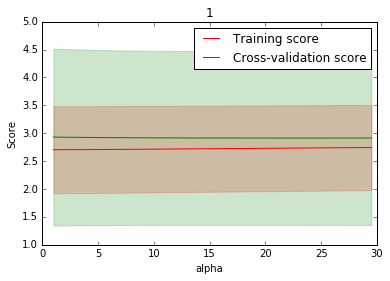

{'alpha': 0.012500000000000001}


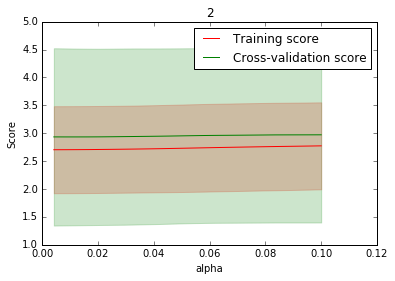

{'n_estimators': 28}


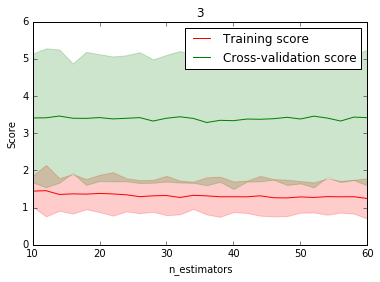

{'min_samples_leaf': 54}


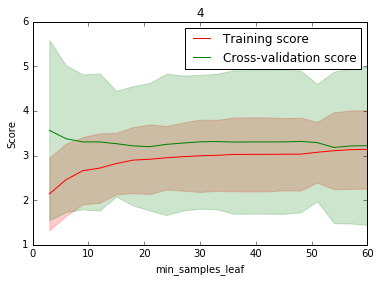

{'n_neighbors': 14}


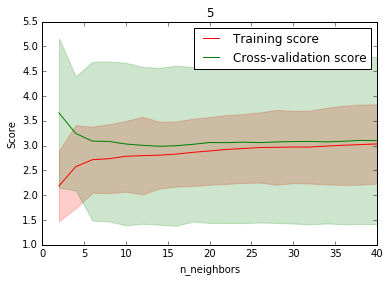

In [36]:
# с помощью функции ниже можно будет построить графики зависимости качества на кросс-валидации для всех
# регрессоров сразу

def plot_validation_curve(reg, reg_parameter, title):
    param_name = list(reg_parameter.keys())[0]
    param_range = list(reg_parameter.values())[0]
    train_scores, test_scores = validation_curve(
        reg, df_train, df_target, param_name=param_name, param_range=param_range,
        cv=5, scoring='mean_squared_error')
    
    # среднее значение берется с минусом, так как оно получается отрицательным. В гугле нашел, что
    # это норма; возможно (я могу быть не прав), это происходит из-за того, что в прописанных
    # в sklearn функциях ошибка максимизируется при анализе качества, и поэтому разработчики
    # решили не напрягаться и стали рассматривать MSE с минусом. В общем, надо смотреть на модуль
    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    train_scores_std = np.sqrt(np.std(train_scores, axis=1))
    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))
    test_scores_std = np.sqrt(np.std(test_scores, axis=1))
    
    plt.figure()
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.plot(param_range, train_scores_mean, label='Training score', color='r')
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='r')
    plt.plot(param_range, test_scores_mean, label='Cross-validation score',
                 color='g')
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color='g')
    plt.legend(loc='best')
    return plt

# теперь найдем нужные гиперпараметры, попутно нарисовав график
for i in range(len(regs)):
    reg = regs[i]
    reg_parameter = regs_parameters[i]
    grid_search = GridSearchCV(reg, reg_parameter, cv=5)
    grid_search.fit(df_train, df_target)
    print(grid_search.best_params_)
    plot_validation_curve(reg, reg_parameter, str(i + 1))
    plt.show()
    
    # в исходном массиве с регрессорами заменим каждый элемент на соответствующий регрессор с найденным
    # значением гиперпараметра
    regs[i] = grid_search.best_estimator_

**4. Оценить качество классификаторов на контроле (например, в качестве функционала ошибок можно использовать RMSE). Выбрать наилучший.**

In [45]:
# новый массив с предсказаниями регрессоров
reg_preds = []

# предсказываем и считаем RMSE
for reg in regs:
    reg_pred = reg.predict(df_control_features)
    reg_preds.append(reg_pred)
    print(np.sqrt(mean_squared_error(df_control_target, reg_pred)))

3.0618385592
3.04858313249
3.20571073172
3.24832343422
3.24325366728


Видно, что на данном разбиении из выбранных регрессоров лучшее качество имеют Ridge и Lasso (первый чуть уступает второму), остальные регрессоры работают чуть хуже (причем решающее дерево и kNN работают почти одинаково).

**5. Рассмотреть простые композиции алгоритмов (хотя бы 2), проверить их качество.**

In [48]:
# сначала берем результаты лучших регрессоров с одинаковыми весами
new_pred1 = 0.5 * reg_preds[0] + 0.5 * reg_preds[1]

# здесь отдаем приоритет самому лучшему регрессору (Lasso), а те, что похуже, включаем с очень
# маленькими весами
new_pred2 = 0.7 * reg_preds[1] + 0.1 * (reg_preds[2] + reg_preds[3] + reg_preds[4])

print(np.sqrt(mean_squared_error(df_control_target, new_pred1)))
print(np.sqrt(mean_squared_error(df_control_target, new_pred2)))

3.05056539043
3.03902318756


Оказалось, что последняя композиция, состоящая из Lasso с большим весом и из Random Forest, решающего дерева и kNN с очень маленькими весами (далее - композиция 2) работает на данной выборке лучше всех рассмотренных алгоритмов. Стоит также заметить, что относительно хорошее качество показывает и композиция из Lasso и Ridge с одинаковыми весами (далее - композиция 1).

**6. Выбрать финальный классификатор, посчитать качество на скрытом контроле.**

In [52]:
# считаем качество композиции 2 на скрытом контроле

final_pred = 0.7 * regs[1].predict(df_concealed_features) + \
     0.1 * (regs[2].predict(df_concealed_features) + regs[3].predict(df_concealed_features) + \
           regs[4].predict(df_concealed_features))
    
print(np.sqrt(mean_squared_error(df_concealed_target, final_pred)))

2.67204253144


**7. Сделать выводы.**

Итак, я рассмотрел работу регрессоров Ridge, Lasso, Random Forest, Decision Tree и kNN на данной случайной выборке, а также двух композиций этих алгоритмов с разными весами. Было установлено, что Ridge и Lasso работают лучше остальных алгоритмов (с небольшим преимуществом последнего), Decision Tree и kNN хуже Random Forest и почти одинаково. Композиции с упором на лучшие алгоритмы дают хорошие результаты, причем композиция 2 даже обгоняет по качеству всё остальное.